## Digital Image Processing, ECE419

Ernesto Colon

The Cooper Union Department of Electrical Engineering

March 31th, 2021

References:
- Ronneberger et al. U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015
- Tensorflow image segmentation example, https://www.tensorflow.org/tutorials/images/segmentation

**The following set of notes and example scripts are part of my independent study sessions.**

## Neural Semantic Segmentation Notes / Exercises - tensorflow

In this script, I will be implementing a U-net for semantic segmentation. I will be using tensorflow/keras to implement
my model. My model architecture follows a very similar pattern to the original U-net published by Ronneberger et al. but
I change a couple of architectural blocks to improve my segmentation accuracy. In particular, I introduce instance
normalization layers to my encoder network to help reduce overfitting and to help the network learn channel-wise features.
In other words, the normalization is computed on a channel-wise basis so that the intensity variations of each channel
maintain their 'character' if you will.

The U-net architecture follows an encoder-decoder pattern. The encoder network applies subsequent convolutional blocks
followed by mas-pooling operations to reduce the feature maps. The main objective is to learn a latent feature map from
the input images somewhat similar to an object detection network. The encoded feature map is then fed into a decoder
network that expands the feature maps back to the input image size. The expansion is accomplished by 2D transpose
convolutional blocks. These blocks basically interpolate our feature map to expand in a controlled manner.

I will be borrowing tensorflow's data ingression pipeline for the Oxford pet dataset.

Each pixel is given one of three categories :

Class 1 : Pixel belonging to the pet.

Class 2 : Pixel bordering the pet.

Class 3 : None of the above/ Surrounding pixel.

In [1]:
# import libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

#### Load the Oxford Pets dataset

In [2]:
# https://www.tensorflow.org/tutorials/images/segmentation
# load oxford pet dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

#### Functions to pre-process and load the data into my model (borrowed from tensorflow's example)

We will be doing random left_right flips to the images as they are input to our neural net as a means to augment our
dataset.

In [3]:
def normalize(input_image, input_mask):
    """
    Function to normalize input images.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1

    return input_image, input_mask


@tf.function
def load_image_train(datapoint):
    """
    Function to load and pre-process training images
    """
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    # Data augmentation by random flips
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    """
    Function to load test set images. This function does not perform random flips.
    """
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

#### Define model training parameters

In [4]:
# dataset already contains the train, validate, and test splits
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

#### Display some of the images

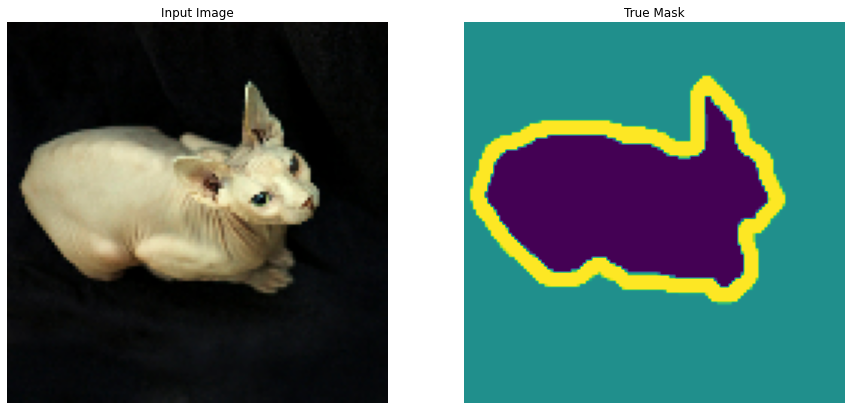

In [5]:
def display(display_list):
    """
    Function to display RGB image next to the true mask and the predicted mask.
    """
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


for image, mask in train.take(1):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])


#### Defining my U-net Model

In [6]:
# Custom downsampling and upsampling convolutional blocks

def downsample_block(x, num_filters, krnl_size,
                     pool_size = 2, activation = 'relu',
                     max_pool = True, dropout_rate = 0.5,
                     reg_flag = True, l2_val=0.001):

    l2_reg = tf.keras.regularizers.l2(l2=l2_val)
    initializer = tf.keras.initializers.RandomNormal(mean=0.0,
                                                     stddev=tf.math.sqrt(2 / (krnl_size * krnl_size * num_filters)))

    # conv block
    if reg_flag:
        x = tf.keras.layers.Conv2D(num_filters, kernel_size=(krnl_size, krnl_size), padding='same', kernel_regularizer=l2_reg, kernel_initializer=initializer)(x)

        x = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True)(x)
        x = tf.keras.layers.Activation(activation)(x)

        x = tf.keras.layers.Conv2D(num_filters, kernel_size=(krnl_size, krnl_size), padding='same', kernel_regularizer=l2_reg, kernel_initializer=initializer)(x)
        x = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True)(x)
        x = tf.keras.layers.Activation(activation)(x)

    else:
        x = tf.keras.layers.Conv2D(num_filters, kernel_size=(krnl_size, krnl_size), padding='same', kernel_initializer=initializer)(x)

        x = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True)(x)
        x = tf.keras.layers.Activation(activation)(x)

        x = tf.keras.layers.Conv2D(num_filters, kernel_size=(krnl_size, krnl_size), padding='same', kernel_initializer=initializer)(x)
        x = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True)(x)
        x = tf.keras.layers.Activation(activation)(x)

    if max_pool:
        x = tf.keras.layers.MaxPool2D(pool_size=(pool_size, pool_size))(x)

    return x


def upsample_block(x, num_filters, krnl_size,
                   activation= 'relu', dropout_rate = 0.5,
                   reg_flag = True, l2_val = 0.001):

    l2_reg = tf.keras.regularizers.l2(l2=l2_val)
    initializer = tf.keras.initializers.RandomNormal(mean=0.0,
                                                     stddev=tf.math.sqrt(2 / (krnl_size * krnl_size * num_filters)))
    if reg_flag:

        x = tf.keras.layers.Conv2D(num_filters, kernel_size=(krnl_size, krnl_size), padding='same', kernel_regularizer=l2_reg, kernel_initializer=initializer)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation)(x)
        x = tf.keras.layers.Conv2D(num_filters, kernel_size=(krnl_size, krnl_size), padding='same', kernel_regularizer=l2_reg, kernel_initializer=initializer)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation)(x)

        x = tf.keras.layers.Dropout(dropout_rate)(x)

    else:

        x = tf.keras.layers.Conv2D(num_filters, kernel_size=(krnl_size, krnl_size), padding='same', kernel_initializer=initializer)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation)(x)
        x = tf.keras.layers.Conv2D(num_filters, kernel_size=(krnl_size, krnl_size), padding='same', kernel_initializer=initializer)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation)(x)

        x = tf.keras.layers.Dropout(dropout_rate)(x)

    return x

#### Compose tensorflow model

In [7]:
inputs = tf.keras.layers.Input(shape=(128, 128, 3))

# DOWNSAMPLING

enc_block_1 = downsample_block(inputs, 64, 3, max_pool=False, reg_flag=False)
enc_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(enc_block_1)

enc_block_2 = downsample_block(enc_pool_1, 128, 3, max_pool=False, reg_flag=False)
enc_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(enc_block_2)

enc_block_3 = downsample_block(enc_pool_2, 256, 3, max_pool=False, reg_flag=False)
enc_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(enc_block_3)

enc_block_4 = downsample_block(enc_pool_3, 512, 3, max_pool=False, reg_flag=False)
enc_pool_4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(enc_block_4)

enc_block_5 = downsample_block(enc_pool_4 ,1024, 3, max_pool=False, reg_flag=False)

enc_block_5 = tf.keras.layers.Dropout(0.5)(enc_block_5)

# UPSAMPLING

# block 6
dec_block_6 = tf.keras.layers.Concatenate()([enc_block_4, tf.keras.layers.Conv2DTranspose(512, kernel_size=(2, 2), strides=2, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=tf.math.sqrt(2 / (4*512))))(enc_block_5)])
dec_block_6 = upsample_block(dec_block_6, 512, 3, reg_flag=False)


# block 7
dec_block_7 = tf.keras.layers.Concatenate()([enc_block_3, tf.keras.layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=2, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=tf.math.sqrt(2 / (4*256))))(dec_block_6)])
dec_block_7 = upsample_block(dec_block_7, 256, 3, reg_flag=False)

# block 8
dec_block_8 = tf.keras.layers.Concatenate()([enc_block_2, tf.keras.layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=2, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=tf.math.sqrt(2 / (4*128))))(dec_block_7)])
dec_block_8 = upsample_block(dec_block_8, 128, 3, reg_flag=False)

# block 9
dec_block_9 = tf.keras.layers.Concatenate()([enc_block_1, tf.keras.layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=2, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=tf.math.sqrt(2 / (4*64))))(dec_block_8)])
dec_block_9 = upsample_block(dec_block_9, 64, 3, reg_flag=False)

# output layer
last = tf.keras.layers.Conv2DTranspose(10, 10, strides=1, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=tf.math.sqrt(2 / (100*10))))(dec_block_9)

model = tf.keras.Model(inputs=inputs, outputs=last)

#### Print Model Summary

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 128, 128, 64) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           instance_normalization[0][0]     
______________________________________________________________________________________________

#### Plot model architecture

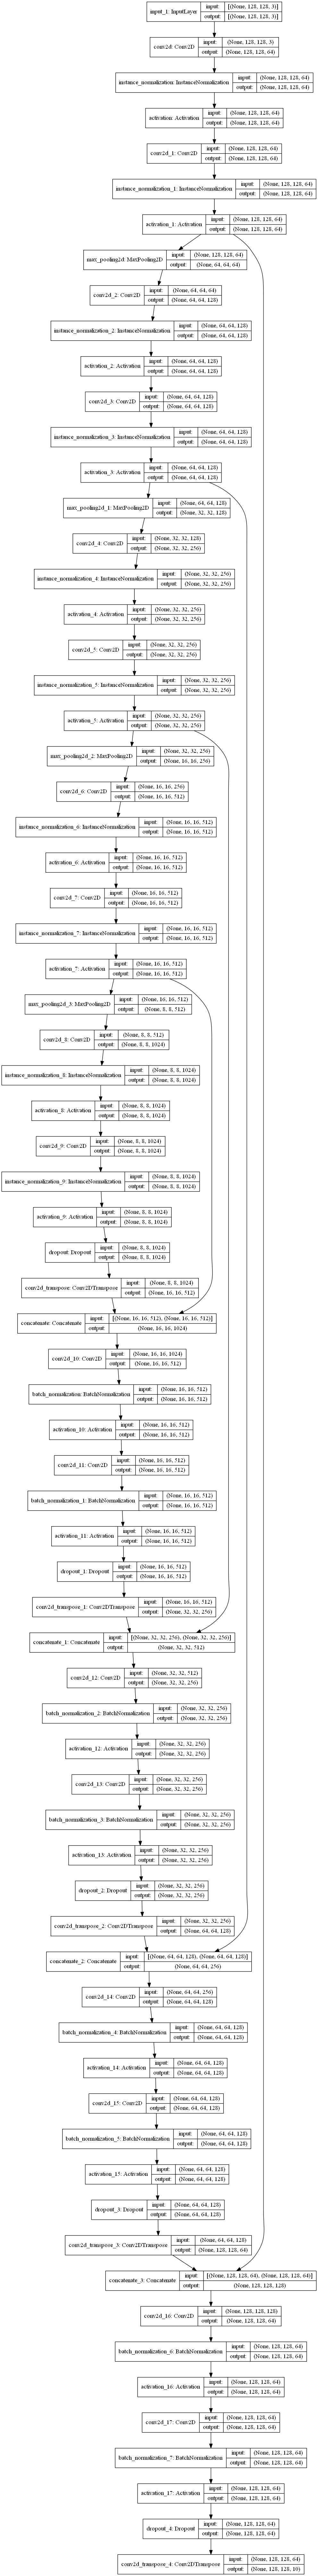

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Compile the model

In [10]:
# compile model
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.96,
    staircase=True)

optim = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

model.compile(optimizer=optim,
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [11]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

#### Train the model

In [12]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/30
230/230 [==============================] - 33s 101ms/step - loss: 1.1793 - accuracy: 0.5842 - val_loss: 1.3056 - val_accuracy: 0.4222 - ETA: 20s - loss: 3.9897 - accuracy: 0.2776 - ETA: 20s - loss: 3.3804 - accuracy: 0.3438

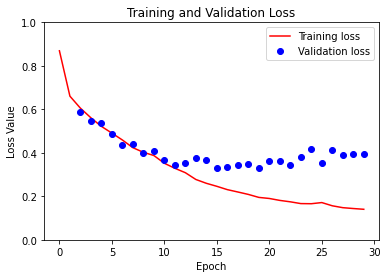

In [13]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


Note from the validation loss plot shown above that our model seems to plateau after 15 epochs or so. In fact, we may
that the validation loss increases slightly.

#### Make predictions

The predicted masks shown below exhibit high accuracy for this particular dataset. We have been able to successfully label
and isolate each pixel of the pets in our dataset with 85+% accuracy. The accuracy of a neural network shows the power of
a deep learning approach for a segmentation task. When contrasted with more traditional digital image processing algorithms,
we can achieve higher accuracy which can come in handy depending on the application at hand. I would argue that this
approach can be used in an image processing pipeline, which is often the case. Of course, the method is not perfect, so
fine tuning may be needed depending on the problem at hand. One of the drawbacks of a deep learning approach, however, is
the need for a large body of labeled training data and the computational cost of training the model. These are trade-offs that need
to be considered when tackling DIP or computer vision applications.

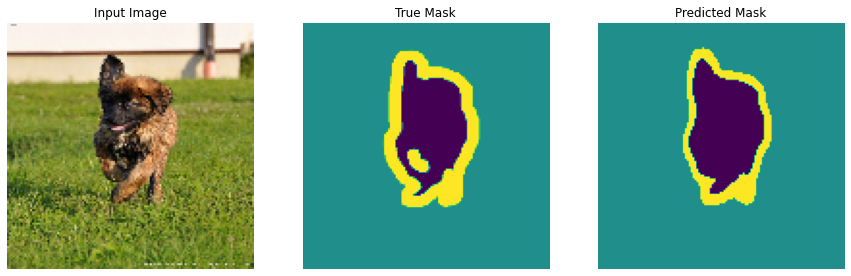

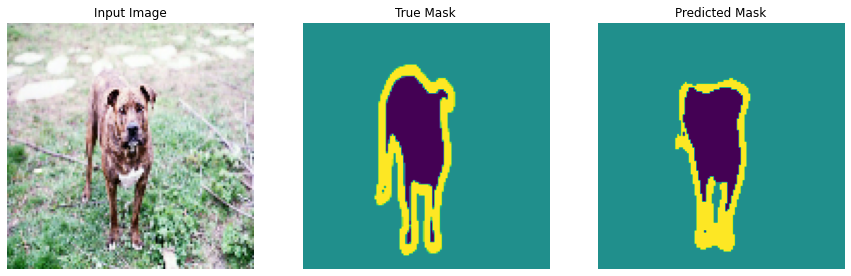

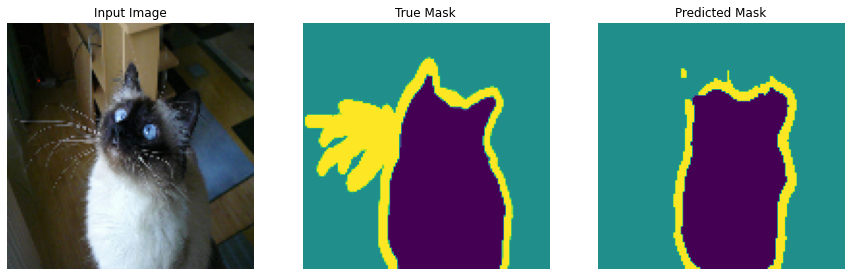

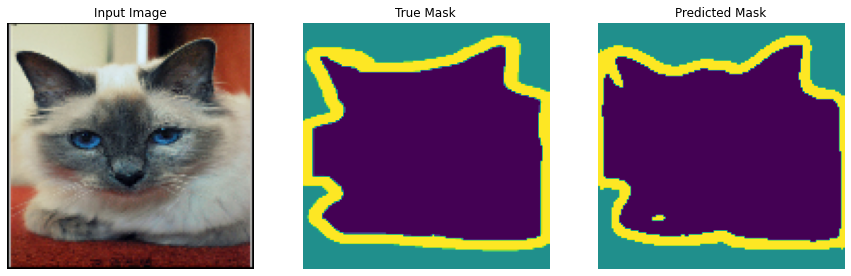

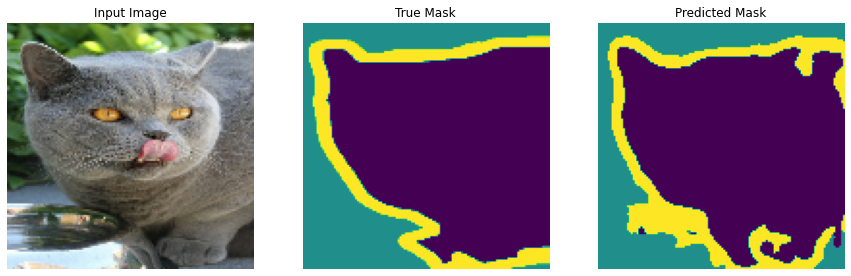

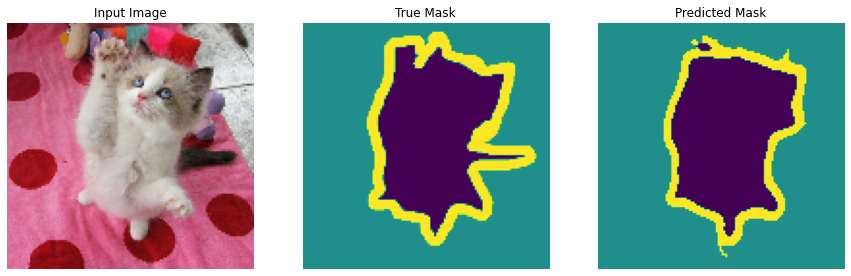

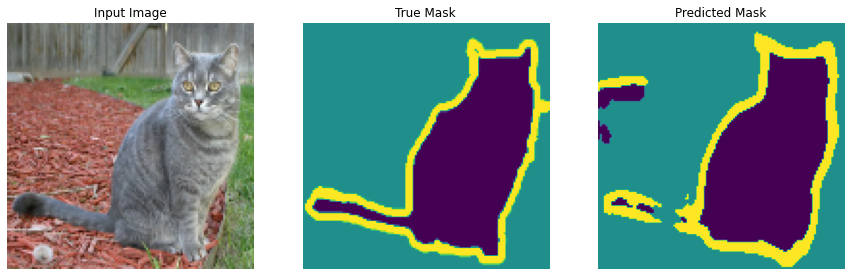

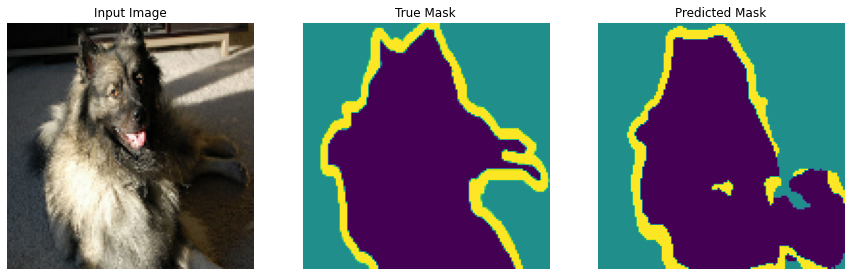

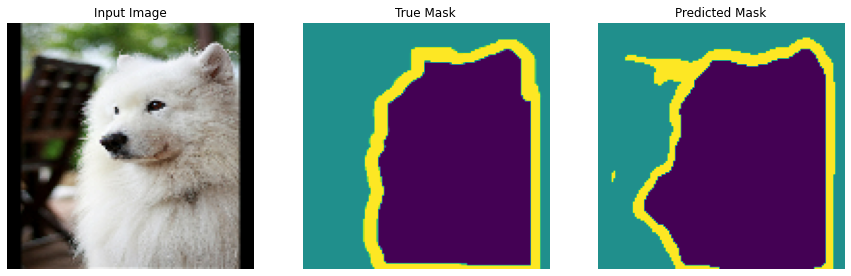

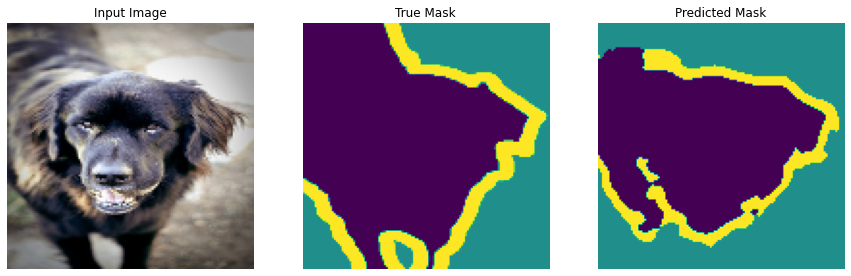

In [14]:
show_predictions(test_dataset, 10)